# CS109b Final Project: 
# Air Pollution Exposure and COVID-19 Mortality in the U.S.

## Import libraries

In [127]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from itertools import product

pd.options.display.max_rows = 500
pd.options.display.max_columns = 500

## Load and clean data

In [2]:
data = pd.read_csv("./../PM_COVID-master/processed_data_04-24-2020.csv")

In [3]:
#load data
#data = pd.read_csv('https://raw.githubusercontent.com/CS109b-Team37/Pollution-Prediction/master/PM_COVID-master/processed_data_04-24-2020.csv')

In [4]:
#rename older_pecent to older_percent
data = data.rename(columns={'older_pecent': 'older_percent'})

#drop columns
cols = list(data.columns)
cols.remove('Unnamed: 0') #just a column of integers 1-21560
#cols.remove('Province_State') #redundant information; already captured by 'state'
cols.remove('Country_Region') #only US
cols.remove('Combined_Key') #redundant information; already captured by 'Province_State' and 'Admin2'
cols.remove('year.x') #only 2016
cols.remove('year.y') #only 2012 and nan
cols.remove('Population') #'older_pecent' was calculated by Population/older_Population
cols.remove('older_Population') #'older_pecent' was calculated by Population/older_Population
cols.remove('date') #only 20200502
cols.remove('hash') #useless information
cols.remove('dateChecked') #only '2020-05-02T20:00:00Z'
cols.remove('Abbrev') #redundant information; already captured by 'state'
cols.remove('total') #almost a repeat of 'totalTestResults'
cols.remove('Recovered') #only 0
data = data[cols]


In [5]:
data['Last_Update'].unique()

array(['2020-04-25 06:30:53', '3/30/20 22:52', '2020-04-25 06:31:05',
       '2020-04-23 00:00:00', '2020-04-24 00:00:00'], dtype=object)

In [6]:
#convert Last_Update to binary variable
convert_dict = {'2020-05-03 02:32:28': 0, '3/30/20 22:52': 1}
data = data.replace({'Last_Update': convert_dict})


In [7]:
#variables with NA values
print('Variables with NA values:')
display(data.isna().sum()[data.isna().sum() > 0])

#remove variables with many NA values
na_vars = list(data.isna().sum()[data.isna().sum() > 50].index) #variables with many NA values
data = data[set(cols) - set(na_vars)] #final cleaned data

Variables with NA values:


smoke_rate                 867
mean_bmi                   867
Crude.Rate                   1
older_percent                1
pending                   2819
hospitalizedCurrently      898
hospitalizedCumulative    1284
inIcuCurrently            1808
inIcuCumulative           2608
onVentilatorCurrently     2155
onVentilatorCumulative    2944
recovered                 1479
hospitalized              1284
beds                       811
dtype: int64

In [8]:
#both NA values are for Loving, Texas
null_data = data[data.isnull().any(axis=1)]
print('Rows with NA values:')
display(null_data)

#fill in NA values for 'Crude.Rate' and 'older_percent' with state average
values = {'Crude.Rate': data.groupby('state').mean()['Crude.Rate']['TX'], 'older_percent': data.groupby('state').mean()['older_percent']['TX']}
data = data.fillna(value=values)

Rows with NA values:


,pct_asian,q_popdensity,Crude.Rate,negative,medhouseholdincome,fips,Province_State,pct_owner_occ,totalTestResults,hospitalizedIncrease,totalTestResultsIncrease,totalTestResults_county,pct_blk,mean_summer_temp,death,popdensity,mean_winter_rm,state,positive,population,older_percent,posNeg,population_frac_county,Confirmed,Lat,positiveIncrease,medianhousevalue,Last_Update,mean_pm25,pct_native,mean_winter_temp,pct_white,mean_summer_rm,Long_,Active,negativeIncrease,poverty,deathIncrease,Deaths,education,Admin2,hispanic
2635,0.0,1,NaN,219741,55625.0,48301,Texas,0.485714,242547,0,17469,0.567672,0.0,309.483185,593,0.395035,72.837808,TX,22806,63,NaN,242547,0.000002,0,31.849476,862,89040.0,1,5.685412,0.047619,290.213523,0.857143,73.844694,-103.581857,0,16607,0.631579,32,0,0.526316,Loving,0.142857


## Add in NY Times County Data with Cumulative Daily Coronavirus Cases & Deaths

In [9]:
url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv'
df_nytimes = pd.read_csv(url,parse_dates=[0])

In [10]:
df_nytimes.shape

(126835, 6)

In [11]:
df_nytimes_today = df_nytimes.loc[df_nytimes.date=='2020-05-02']

print("Deaths in counties with NULL FIPS: ", 
      df_nytimes_today.loc[df_nytimes_today['fips'].isnull()==True]['deaths'].sum(),
     '| Number of counties: ', len(df_nytimes_today.loc[df_nytimes_today['fips'].isnull()==True]))


print("Deaths in New York County (biggest area with NULL FIPS): ", 
      df_nytimes_today.loc[df_nytimes_today['county']=='New York City']['deaths'].sum())

print("Deaths in counties with correct FIPS: ", 
      df_nytimes_today.loc[df_nytimes_today['fips'].isnull()==False]['deaths'].sum(),
     '| Number of counties: ', len(df_nytimes_today.loc[df_nytimes_today['fips'].isnull()==False]))

print("Total Deaths: ", df_nytimes_today['deaths'].sum(),
          '| Number of counties: ', len(df_nytimes_today))


Deaths in counties with NULL FIPS:  18424 | Number of counties:  28
Deaths in New York County (biggest area with NULL FIPS):  18021
Deaths in counties with correct FIPS:  48031 | Number of counties:  2837
Total Deaths:  66455 | Number of counties:  2865


In [12]:
data['fips_new']=data['fips'].astype(int).apply(lambda x: '{0:0>5}'.format(x)) #add leading zeros to fips code
#data['fips_new']=data['fips'].astype(int)
df_nytimes_clean = df_nytimes.loc[df_nytimes['fips'].isnull()==False]
df_nytimes_clean['fips_new']=df_nytimes_clean['fips'].astype(int)
df_nytimes_clean['fips_new']=df_nytimes_clean['fips_new'].astype(object)
df_nytimes_clean['fips_new'] = df_nytimes_clean['fips_new'].apply(lambda x: '{0:0>5}'.format(x)) #add leading zeros to fips code


In [13]:
df_nytimes_clean['week']=df_nytimes_clean['date'].dt.week
df_nytimes_clean['dayofweek']=df_nytimes_clean['date'].dt.dayofweek
df_nytimes_clean = df_nytimes_clean.loc[df_nytimes_clean['dayofweek']==6] #cumulative data so want the end of week numbers

df_joined = df_nytimes_clean[['week','dayofweek',
                              'date','cases','deaths','fips_new']].merge(data, 
                                                                         on ='fips_new', 
                                                                         how = 'left')

In [14]:
df_joined.head()

,week,dayofweek,date,cases,deaths,fips_new,pct_asian,q_popdensity,Crude.Rate,negative,medhouseholdincome,fips,Province_State,pct_owner_occ,totalTestResults,hospitalizedIncrease,totalTestResultsIncrease,totalTestResults_county,pct_blk,mean_summer_temp,death,popdensity,mean_winter_rm,state,positive,population,older_percent,posNeg,population_frac_county,Confirmed,Lat,positiveIncrease,medianhousevalue,Last_Update,mean_pm25,pct_native,mean_winter_temp,pct_white,mean_summer_rm,Long_,Active,negativeIncrease,poverty,deathIncrease,Deaths,education,Admin2,hispanic
0,4,6,2020-01-26,1,0,04013,0.036367,4.0,693.5,54669.0,60944.201550,4013.0,Arizona,0.623470,60714.0,984.0,2017.0,38974.518658,0.046994,312.887974,266.0,3052.496587,62.523577,AZ,6045.0,4046686.0,0.123367,60714.0,0.641936,3116.0,33.348359,276.0,231863.424947,2020-04-25 06:30:53,8.962005,0.028066,292.696006,0.797530,43.955582,-112.491815,2996.0,1741.0,0.098313,17.0,120.0,0.150852,Maricopa,0.275227
1,4,6,2020-01-26,1,0,06037,0.147261,4.0,607.1,454919.0,66320.068841,6037.0,California,0.476622,494173.0,0.0,12076.0,128181.698676,0.079818,303.265427,1562.0,9070.950193,68.943495,CA,39254.0,10014553.0,0.107776,494173.0,0.259386,18545.0,34.308284,1885.0,567463.413043,2020-04-25 06:30:53,15.718274,0.005423,289.471635,0.556419,66.843499,-118.228241,17695.0,10191.0,0.141721,93.0,850.0,0.272456,Los Angeles,0.405115
2,4,6,2020-01-26,1,0,06059,0.189658,4.0,587.3,454919.0,85843.886364,6059.0,California,0.582866,494173.0,0.0,12076.0,40163.352229,0.015781,300.790590,1562.0,6243.631658,79.082530,CA,39254.0,3137874.0,0.114021,494173.0,0.081274,1845.0,33.701475,1885.0,679449.573485,2020-04-25 06:30:53,15.786018,0.004064,292.609396,0.657640,87.075159,-117.764600,1809.0,10191.0,0.085636,93.0,36.0,0.152671,Orange,0.277774
3,4,6,2020-01-26,1,0,17031,0.073987,4.0,797.2,149974.0,68431.961145,17031.0,Illinois,0.619800,189632.0,0.0,16316.0,76229.155040,0.228933,301.073461,1795.0,8452.935641,84.994321,IL,39658.0,5163056.0,0.121084,189632.0,0.401985,27616.0,41.841448,2724.0,259563.190184,2020-04-25 06:30:53,13.370310,0.002347,274.406491,0.605275,83.073103,-87.816588,26396.0,13592.0,0.117719,107.0,1220.0,0.199716,Cook,0.186945
4,4,6,2020-01-26,1,0,53061,0.078867,4.0,644.9,161533.0,73485.148148,53061.0,Washington,0.678889,174830.0,0.0,3199.0,18646.154807,0.021852,294.490555,659.0,2276.842087,92.912894,WA,13297.0,753416.0,0.104065,174830.0,0.106653,2243.0,48.046160,302.0,292496.296296,2020-04-24 00:00:00,6.391097,0.010321,278.238279,0.811078,80.565422,-121.717070,2141.0,2897.0,0.082732,5.0,102.0,0.114099,Snohomish,0.083849


In [15]:
print(len(df_joined.loc[df_joined['mean_pm25'].isnull()==True]['fips_new'].unique()))
df_joined = df_joined.dropna(subset=['mean_pm25'], how='all')


39


In [16]:
len(df_joined), len(df_nytimes_clean), len(data)

(16879, 17094, 3086)

//anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


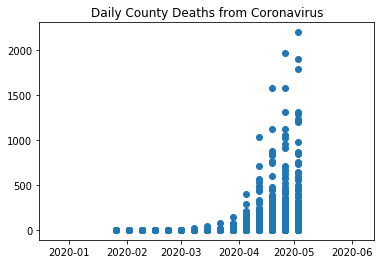

In [17]:
plt.scatter(df_joined['date'],df_joined['deaths'])
plt.title("Daily County Deaths from Coronavirus")
plt.show()

## Modeling

**Data Cleaning for Models**

In [18]:
simple_columns = ['fips_new','week','date', 'cases', 'deaths','mean_pm25']

In [19]:
demographic_columns = ['fips_new','week','date', 'cases', 'deaths','mean_pm25',
                                  'pct_native','popdensity','older_percent',
                                  'hispanic','Long_','population','population_frac_county', 
                                  'poverty', 'mean_summer_temp','Lat',
                                  'mean_winter_rm', 'education', 'mean_winter_temp',
                                  'pct_owner_occ', 'medhouseholdincome', 'medianhousevalue', 'pct_asian',
                                  'pct_white', 'pct_blk']

In [23]:
df_simple = df_joined[simple_columns]

df_simple = df_simple.groupby(['fips_new','week']).agg({'cases':'sum', 'deaths': 'sum', 'mean_pm25':'mean'})

df_simple=df_simple.reset_index()

In [24]:
X_train_simple = df_simple.loc[df_simple['week']<18 ][['mean_pm25','week']]
y_train_simple = df_simple.loc[df_simple['week']<18][['deaths']]
X_test_simple = df_simple.loc[df_simple['week']==18][['mean_pm25','week']]
y_test = df_simple.loc[df_simple['week']==18][['deaths']] #only need to filter y_test once for all models


In [25]:
df_demographic = df_joined[demographic_columns]

df_demographic = df_demographic.groupby(['fips_new','week']).agg(
    {
        'cases':'sum',
        'deaths':'sum',
        'mean_pm25':'mean',
        'pct_native':'mean',
        'popdensity':'mean',
        'older_percent':'mean',
        'hispanic':'mean',
        'Long_':'mean',
        'population':'mean',
        'population_frac_county':'mean', 
        'poverty':'mean', 
        'mean_summer_temp':'mean',
        'Lat':'mean',
        'mean_winter_rm':'mean', 
        'education':'mean', 
        'mean_winter_temp':'mean',
        'pct_owner_occ':'mean', 
        'medhouseholdincome':'mean', 
        'medianhousevalue':'mean', 
        'pct_asian':'mean',
        'pct_white':'mean', 
        'pct_blk':'mean'        
    })

df_demographic=df_demographic.reset_index()

In [47]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(df_demographic, test_size=.15, random_state = 97)

#### Polynomial Regressions

In response to the shortcomings of the simple linear models I decided to train models with higher order terms - specifically, squared terms for all predictors and also squared and cubic terms for all predictors - to see how much of the problem was caused by an inability to capture more complicated relationships. These regressions all predict weekly COVID-19 deaths from different sets of predictors that will be used for much of my code. The first set of predictors consists of only the week number (a simplified measure of time) and the PM2.5 particulate matter metric. The second set of predictors includes all of those in the merged datasets, including demographic information, climate metrics, and more. The third set of predictors is the second set of predictors without the PM2.5 particulate matter data. The goal was to learn more about the relationship between particulate matter and deaths as well as the importance and usefulness of particulate matter metrics to the accuracy of predictive models. 

First I fit linear models for these sets of predictors to serve as baselines. 

In [215]:
# fit linear baselines
from sklearn.linear_model import LinearRegression
linear_1 = LinearRegression().fit(X_train[predictors_1], X_train.deaths)
linear_2 = LinearRegression().fit(X_train[predictors_2], X_train.deaths)
linear_3 = LinearRegression().fit(X_train[predictors_3], X_train.deaths)
mse1 = mean_squared_error(linear_1.predict(X_test[predictors_1]), X_test.deaths) 
mse2 = mean_squared_error(linear_2.predict(X_test[predictors_2]), X_test.deaths) 
mse3 = mean_squared_error(linear_3.predict(X_test[predictors_3]), X_test.deaths) 
print("MSE 1:", mse1, "\nMSE 2:", mse2, "\nMSE 3:", mse3)

MSE 1: 3068.3203136475977 
MSE 2: 2587.6982214000086 
MSE 3: 2587.516771445464


**Model 1**: Simple

In [41]:
# bring in functions for generating polynomial models
import statsmodels.formula.api as sm
from sklearn.preprocessing import PolynomialFeatures

In [170]:
# smallest list of predictors described above
predictors_1 = [i for i in df_simple.columns if i not in ['fips_new', 'cases', 'deaths']]

###regression with degree 2 and 3 polynomial basis functions
squared_formula_1 = 'deaths ~ '
cubic_formula_1 = 'deaths ~ '
# iterate over the predictors to write out the formulas
for i in predictors_1: 
    if i != 'room_type':
        squared_formula_1 += '{} + np.power({}, 2) + '.format(i, i)
        cubic_formula_1 += '{} + np.power({}, 2) + np.power({}, 3) + '.format(i, i, i)
squared_formula_1 = squared_formula_1[:-3]
cubic_formula_1 = cubic_formula_1[:-3]
# instantiate and fit the models
squared_model_1 = sm.ols(formula = squared_formula_1, data = X_train).fit()
cubic_model_1 = sm.ols(formula = cubic_formula_1, data = X_train).fit()

In [171]:
# fit models on the test set and display MSEs
mse_sq = mean_squared_error(squared_model_1.predict(X_test), X_test['deaths'])
mse_cu = mean_squared_error(cubic_model_1.predict(X_test), X_test['deaths'])
print('Quadratic Model:', squared_formula_1, '\n\nQuadratic Model MSE:', mse_sq, 
      '\n\nCubic Model:', cubic_formula_1, '\n\nCubic Model MSE:', mse_cu)

Quadratic Model: deaths ~ week + np.power(week, 2) + mean_pm25 + np.power(mean_pm25, 2) 

Quadratic Model MSE: 3036.2247671205905 

Cubic Model: deaths ~ week + np.power(week, 2) + np.power(week, 3) + mean_pm25 + np.power(mean_pm25, 2) + np.power(mean_pm25, 3) 

Cubic Model MSE: 3024.01155416844


**Model 2**: Full demographics

In [172]:
# create list of full set of demographic predictors
predictors_2 = [i for i in df_demographic.columns if i not in ['fips_new', 'cases', 'deaths']]

###regression with degree 2 and 3 polynomial basis functions
squared_formula_2 = 'deaths ~ '
cubic_formula_2 = 'deaths ~ '
# iterate over the predictors to write out the formulas
for i in predictors_2: 
    if i != 'room_type':
        squared_formula_2 += '{} + np.power({}, 2) + '.format(i, i)
        cubic_formula_2 += '{} + np.power({}, 2) + np.power({}, 3) + '.format(i, i, i)
squared_formula_2 = squared_formula_2[:-3]
cubic_formula_2 = cubic_formula_2[:-3]
# instantiate and fit the models
squared_model_2 = sm.ols(formula = squared_formula_2, data = X_train).fit()
cubic_model_2 = sm.ols(formula = cubic_formula_2, data = X_train).fit()

In [173]:
# fit models on the test set and display MSEs
mse_sq = mean_squared_error(squared_model_2.predict(X_test), X_test['deaths'])
mse_cu = mean_squared_error(cubic_model_2.predict(X_test), X_test['deaths'])
print('Quadratic Model:', squared_formula_2, '\n\nQuadratic Model MSE:', mse_sq, 
      '\n\nCubic Model:', cubic_formula_2, '\n\nCubic Model MSE:', mse_cu)

Quadratic Model: deaths ~ week + np.power(week, 2) + mean_pm25 + np.power(mean_pm25, 2) + pct_native + np.power(pct_native, 2) + popdensity + np.power(popdensity, 2) + older_percent + np.power(older_percent, 2) + hispanic + np.power(hispanic, 2) + Long_ + np.power(Long_, 2) + population + np.power(population, 2) + population_frac_county + np.power(population_frac_county, 2) + poverty + np.power(poverty, 2) + mean_summer_temp + np.power(mean_summer_temp, 2) + Lat + np.power(Lat, 2) + mean_winter_rm + np.power(mean_winter_rm, 2) + education + np.power(education, 2) + mean_winter_temp + np.power(mean_winter_temp, 2) + pct_owner_occ + np.power(pct_owner_occ, 2) + medhouseholdincome + np.power(medhouseholdincome, 2) + medianhousevalue + np.power(medianhousevalue, 2) + pct_asian + np.power(pct_asian, 2) + pct_white + np.power(pct_white, 2) + pct_blk + np.power(pct_blk, 2) 

Quadratic Model MSE: 2413.4023680570795 

Cubic Model: deaths ~ week + np.power(week, 2) + np.power(week, 3) + mean_pm2

**Model 3:**
No particulate matter data

In [174]:
# create list of full demographic and other predictors without pm25 data
predictors_3 = [i for i in df_demographic.columns if i not in ['fips_new', 'cases', 'deaths', 'mean_pm25']]

###regression with degree 2 and 3 polynomial basis functions
squared_formula_3 = 'deaths ~ '
cubic_formula_3 = 'deaths ~ '
# iterate over the predictors to write out the formulas
for i in predictors_3: 
    if i != 'room_type':
        squared_formula_3 += '{} + np.power({}, 2) + '.format(i, i)
        cubic_formula_3 += '{} + np.power({}, 2) + np.power({}, 3) + '.format(i, i, i)
squared_formula_3 = squared_formula_3[:-3]
cubic_formula_3 = cubic_formula_3[:-3]
# instantiate and fit the models
squared_model_3 = sm.ols(formula = squared_formula_3, data = X_train).fit()
cubic_model_3 = sm.ols(formula = cubic_formula_3, data = X_train).fit()

In [175]:
# fit models on the test set and display MSEs
mse_sq = mean_squared_error(squared_model_3.predict(X_test), X_test['deaths'])
mse_cu = mean_squared_error(cubic_model_3.predict(X_test), X_test['deaths'])
print('Quadratic Model:', squared_formula_3, '\n\nQuadratic Model MSE:', mse_sq, 
      '\n\nCubic Model:', cubic_formula_3, '\n\nCubic Model MSE:', mse_cu)

Quadratic Model: deaths ~ week + np.power(week, 2) + pct_native + np.power(pct_native, 2) + popdensity + np.power(popdensity, 2) + older_percent + np.power(older_percent, 2) + hispanic + np.power(hispanic, 2) + Long_ + np.power(Long_, 2) + population + np.power(population, 2) + population_frac_county + np.power(population_frac_county, 2) + poverty + np.power(poverty, 2) + mean_summer_temp + np.power(mean_summer_temp, 2) + Lat + np.power(Lat, 2) + mean_winter_rm + np.power(mean_winter_rm, 2) + education + np.power(education, 2) + mean_winter_temp + np.power(mean_winter_temp, 2) + pct_owner_occ + np.power(pct_owner_occ, 2) + medhouseholdincome + np.power(medhouseholdincome, 2) + medianhousevalue + np.power(medianhousevalue, 2) + pct_asian + np.power(pct_asian, 2) + pct_white + np.power(pct_white, 2) + pct_blk + np.power(pct_blk, 2) 

Quadratic Model MSE: 2413.6317936529217 

Cubic Model: deaths ~ week + np.power(week, 2) + np.power(week, 3) + pct_native + np.power(pct_native, 2) + np.pow

### Linear Models with Interactions

In the interest of prediction, for which having a parametric model that learns generalizable principles about the relationship between COVID mortality and time is useful, we fit some linear models with interaction terms as well. Specifically, we made these models linear regressions with degree 2, including all interaction terms and square terms. We examined the same three predictor ensembles described previously. 

In [248]:
# get useful functions
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_boston
from sklearn.preprocessing import PolynomialFeatures

# transform to get interactions, fit models, find mse
# fit for PM and weeks
interaction = PolynomialFeatures(degree=2, include_bias=True)
X_tr_inter_1 = interaction.fit_transform(X_train[predictors_1])
inter_1 = LinearRegression().fit(X_tr_inter_1, X_train.deaths)
X_te_inter_1 = interaction.fit_transform(X_test[predictors_1])
mse1 = mean_squared_error(inter_1.predict(X_te_inter_1), X_test.deaths)
# repeat for full ensemble
interaction = PolynomialFeatures(degree=2, include_bias=True)
X_tr_inter_2 = interaction.fit_transform(X_train[predictors_2])
inter_2 = LinearRegression().fit(X_tr_inter_2, X_train.deaths)
X_te_inter_2 = interaction.fit_transform(X_test[predictors_2])
mse2 = mean_squared_error(inter_2.predict(X_te_inter_2), X_test.deaths)
# repeat for full ensemble without PM
interaction = PolynomialFeatures(degree=2, include_bias=True)
X_tr_inter_3 = interaction.fit_transform(X_train[predictors_3])
inter_3 = LinearRegression().fit(X_tr_inter_3, X_train.deaths)
X_te_inter_3 = interaction.fit_transform(X_test[predictors_3])
mse3 = mean_squared_error(inter_3.predict(X_te_inter_3), X_test.deaths)
print("MSE 1:", mse1, "\nMSE 2:", mse2, "\nMSE 3:", mse3)

MSE 1: 3001.2094487090703 
MSE 2: 1686.617632831484 
MSE 3: 1668.8870973329767


### LASSO
It looked like we were likely overfitting, so regularization seemed like the logical next step. We cross validated to find the appropriate regularization parameter and used the same three predictor ensembles described before. 

In [255]:
# import function for cross validation, lasso
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso

# define a function that performs cross validation wrt regularization parameter
def cvreg(X_train, y_train):
    alphas = [.001, .01, .1, 1]
    cvmeans = {} 
    for i in alphas:
        model = Lasso(alpha = i) #fit model
        score = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 5, n_jobs = -1, scoring = 'neg_mean_squared_error') #perform 5-fold CV
        cvmeans[i] = -score.mean() #store average score of all 5 folds
    return cvmeans

In [256]:
# for each ensemble, find the optimal alpha and fit
regdict = cvreg(X_tr_inter_1, X_train.deaths)
alphag = min(regdict, key=regdict.get)
lasso_1 = Lasso(alpha = alphag).fit(X_tr_inter_1, X_train.deaths)
mse1 = mean_squared_error(lasso_1.predict(X_te_inter_1), X_test.deaths)
regdict = cvreg(X_tr_inter_2, X_train.deaths)
alphag = min(regdict, key=regdict.get)
lasso_2 = Lasso(alpha = alphag).fit(X_tr_inter_2, X_train.deaths)
mse2 = mean_squared_error(lasso_2.predict(X_te_inter_2), X_test.deaths)
regdict = cvreg(X_tr_inter_3, X_train.deaths)
alphag = min(regdict, key=regdict.get)
lasso_3 = Lasso(alpha = alphag).fit(X_tr_inter_3, X_train.deaths)
mse3 = mean_squared_error(lasso_3.predict(X_te_inter_3), X_test.deaths)
print("MSE 1:", mse1, "\nMSE 2:", mse2, "\nMSE 3:", mse3)

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2518041.433327846, tolerance: 5592.815819516274
  positive)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13042017.880212758, tolerance: 5592.815819516274
  positive)


MSE 1: 3001.21107320563 
MSE 2: 1479.937775856951 
MSE 3: 1467.6924154256928


//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13163847.178062111, tolerance: 5592.815819516274
  positive)


### GAMs

In order to further probe the predictive power of modeling the relationships between the predictors and COVID deaths more flexibly, we fit GAMs using pygam. Three models are fit that are analagous to those fit in the polynomial cases, with the first using only two predictors, the second using all predictors, and the third using all predictors except for particulate matter data. Smoothing was determined through 5-fold cross validation selecting for the lowest average validation set MSE for all models and 50 splines were used as a sensible default. Once fit, models were evaluated and analyzed through test set MSE, summaries with smooth significances, and plots of smooth contributions to the overall model. 

In [115]:
# import necessary functions to create GAMs
from pygam import LinearGAM, s, f
from sklearn.preprocessing import LabelEncoder

In [118]:
# Simplest Model
###fit GAM 

#set up cross validation
candidate_smoothings = [0, 0.0001, 0.001, 0.01, 0.03, 0.1, 1, 10, 100, 1000]
kf = KFold(n_splits = 5, random_state = 47, shuffle = True)
mses = np.zeros((5, len(candidate_smoothings)))

#perform cross validation
for i, (train_index, val_index) in enumerate(kf.split(X_train)):
    train_df = X_train.iloc[train_index,:]
    val_df = X_train.iloc[val_index,:]
    for j, cur_smoothing in enumerate(candidate_smoothings):
        gam = LinearGAM(s(0) + s(1), 
                        lam = cur_smoothing, n_splines = 50).fit(train_df[predictors_1], train_df.deaths)        
        mses[i,j] = mean_squared_error(val_df.deaths, gam.predict(val_df[predictors_1]))

#identify best smoothing parameter
bestlam = candidate_smoothings[np.argmax(np.sum(mses, axis = 0))]

#fit model using best smoothing parameter
gam_1 = LinearGAM(s(0) + s(1), 
                lam = bestlam, n_splines = 50).fit(X_train[predictors_1], X_train.deaths) 

#print results
print('best smoothing parameter, as determined by cross-validation:', bestlam)
print('MSE, GAM, training set:', mean_squared_error(X_train.deaths, gam_1.predict(X_train[predictors_1])),
      '\nMSE, GAM, test set:', mean_squared_error(X_test.deaths, gam_1.predict(X_test[predictors_1])))

best smoothing parameter, as determined by cross-validation: 10
MSE, GAM, training set: 3767.5357447578194 
MSE, GAM, test set: 3029.4082947511197


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     40.7129
Link Function:                     IdentityLink Log Likelihood:                               -131362.4042
Number of Samples:                        14347 AIC:                                           262808.2343
                                                AICc:                                          262808.4834
                                                GCV:                                             3797.6506
                                                Scale:                                           3778.2574
                                                Pseudo R-Squared:                                   0.0335
Feature Function                  Lam

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 



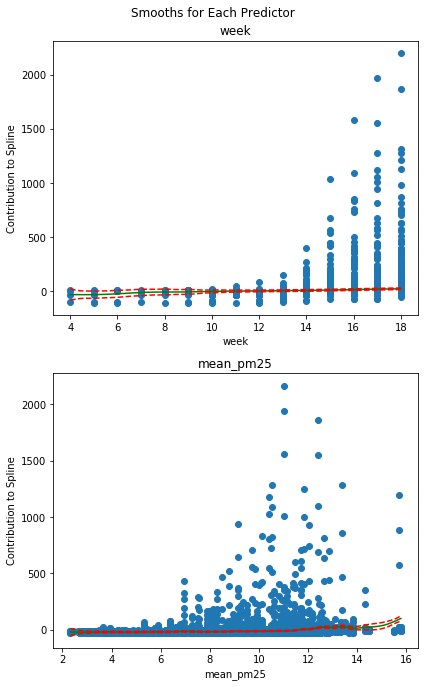

In [120]:
#plot the smooth of each predictor
res = gam_1.deviance_residuals(X_train[predictors_1], X_train.deaths) 
X = X_train[predictors_1]

fig, ax = plt.subplots(2, 1, figsize = (6, 10))

#iterate through each predictor
for i, term in enumerate(gam_1.terms):
    if term.isintercept:
        continue
    XX = gam_1.generate_X_grid(term = i)
    pdep, confi = gam_1.partial_dependence(term = i, X = XX, width=0.95)
    pdep2, _ = gam_1.partial_dependence(term = i, X = X, width=0.95)
    #plt.figure()
    ax[i].scatter(X.iloc[:,term.feature], pdep2 + res)
    ax[i].plot(XX[:, term.feature], pdep, c = 'g')
    ax[i].plot(XX[:, term.feature], confi, c = 'r', ls='--')
    ax[i].set_title(X.columns.values[term.feature])
    ax[i].set_xlabel(X.columns.values[term.feature])
    ax[i].set_ylabel('Contribution to Spline')
    #ax[i].show()

#add title
fig.suptitle('Smooths for Each Predictor')
plt.tight_layout(rect = [0, 0.03, 1, 0.97]);

# show a summary of the model
gam_1.summary()

In [122]:
# Full model with demographics

###fit GAM 

#set up cross validation
candidate_smoothings = [0, 0.0001, 0.001, 0.01, 0.03, 0.1, 1, 10, 100, 1000]
mses = np.zeros((5, len(candidate_smoothings)))

#perform cross validation
for i, (train_index, val_index) in enumerate(kf.split(X_train)):
    train_df = X_train.iloc[train_index,:]
    val_df = X_train.iloc[val_index,:]
    for j, cur_smoothing in enumerate(candidate_smoothings):
        gam = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + 
                        s(11) + s(12) + s(13) + s(14) + s(15) + s(16) + s(17) + s(18) + s(19) + s(20), 
                        lam = cur_smoothing, n_splines = 50).fit(train_df[predictors_2], train_df.deaths)        
        mses[i,j] = mean_squared_error(val_df.deaths, gam.predict(val_df[predictors_2]))

#identify best smoothing parameter
bestlam = candidate_smoothings[np.argmax(np.sum(mses, axis = 0))]

#fit model using best smoothing parameter
gam_2 = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + 
                s(11) + s(12) + s(13) + s(14) + s(15) + s(16) + s(17) + s(18) + s(19) + s(20), 
                lam = bestlam, n_splines = 50).fit(X_train[predictors_2], X_train.deaths) 

#print results
print('best smoothing parameter, as determined by cross-validation:', bestlam)
print('MSE, GAM, training set:', mean_squared_error(X_train.deaths, gam_2.predict(X_train[predictors_2])),
      '\nMSE, GAM, test set:', mean_squared_error(X_test.deaths, gam_2.predict(X_test[predictors_2])))

best smoothing parameter, as determined by cross-validation: 0
MSE, GAM, training set: 2089.3581489976877 
MSE, GAM, test set: 2532.149965428197


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    810.0285
Link Function:                     IdentityLink Log Likelihood:                               -123698.1133
Number of Samples:                        14347 AIC:                                           249018.2836
                                                AICc:                                          249115.5986
                                                GCV:                                             2463.3995
                                                Scale:                                           2214.3817
                                                Pseudo R-Squared:                                    0.464
Feature Function                  Lam

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 



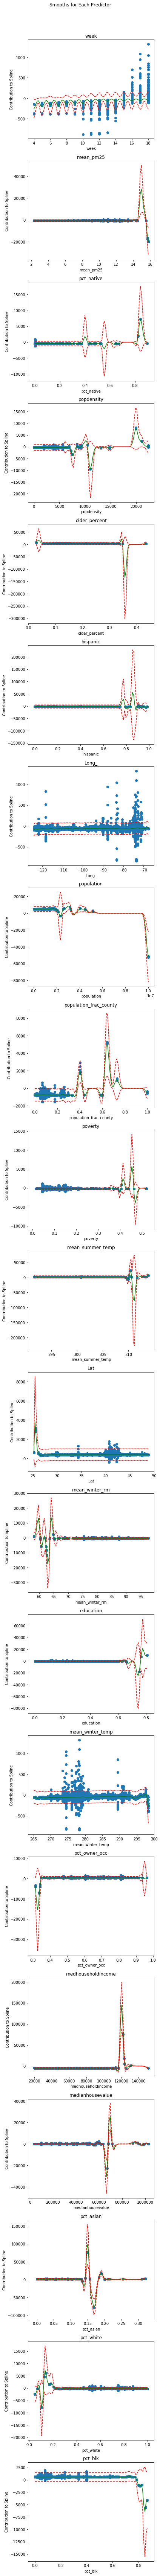

In [123]:
#plot the smooth of each predictor
res = gam_2.deviance_residuals(X_train[predictors_2], X_train.deaths) 
X = X_train[predictors_2]

fig, ax = plt.subplots(21, 1, figsize = (6, 100))

#iterate through each predictor
for i, term in enumerate(gam_2.terms):
    if term.isintercept:
        continue
    XX = gam_2.generate_X_grid(term = i)
    pdep, confi = gam_2.partial_dependence(term = i, X = XX, width=0.95)
    pdep2, _ = gam_2.partial_dependence(term = i, X = X, width=0.95)
    #plt.figure()
    ax[i].scatter(X.iloc[:,term.feature], pdep2 + res)
    ax[i].plot(XX[:, term.feature], pdep, c = 'g')
    ax[i].plot(XX[:, term.feature], confi, c = 'r', ls='--')
    ax[i].set_title(X.columns.values[term.feature])
    ax[i].set_xlabel(X.columns.values[term.feature])
    ax[i].set_ylabel('Contribution to Spline')
    #ax[i].show()

#add title
fig.suptitle('Smooths for Each Predictor')
plt.tight_layout(rect = [0, 0.03, 1, 0.97]);

# show a summary of the model
gam_2.summary()

In [ ]:
# COME BACK TO THIS - DETERMINE WHICH FEATURES ARE SIGNIFICANT

In [124]:
# Full model with demographics but not pm

###fit GAM 

#set up cross validation
candidate_smoothings = [0, 0.0001, 0.001, 0.01, 0.03, 0.1, 1, 10, 100, 1000]
mses = np.zeros((5, len(candidate_smoothings)))

#perform cross validation
for i, (train_index, val_index) in enumerate(kf.split(X_train)):
    train_df = X_train.iloc[train_index,:]
    val_df = X_train.iloc[val_index,:]
    for j, cur_smoothing in enumerate(candidate_smoothings):
        gam = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + 
                        s(11) + s(12) + s(13) + s(14) + s(15) + s(16) + s(17) + s(18) + s(19), 
                        lam = cur_smoothing, n_splines = 50).fit(train_df[predictors_3], train_df.deaths)        
        mses[i,j] = mean_squared_error(val_df.deaths, gam.predict(val_df[predictors_3]))

#identify best smoothing parameter
bestlam = candidate_smoothings[np.argmax(np.sum(mses, axis = 0))]

#fit model using best smoothing parameter
gam_3 = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + 
                s(11) + s(12) + s(13) + s(14) + s(15) + s(16) + s(17) + s(18) + s(19), 
                lam = bestlam, n_splines = 50).fit(X_train[predictors_3], X_train.deaths) 

#print results
print('best smoothing parameter, as determined by cross-validation:', bestlam)
print('MSE, GAM, training set:', mean_squared_error(X_train.deaths, gam_3.predict(X_train[predictors_3])),
      '\nMSE, GAM, test set:', mean_squared_error(X_test.deaths, gam_3.predict(X_test[predictors_3])))

best smoothing parameter, as determined by cross-validation: 0
MSE, GAM, training set: 2094.81877919444 
MSE, GAM, test set: 2483.5368800561187


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    765.0742
Link Function:                     IdentityLink Log Likelihood:                               -123688.0079
Number of Samples:                        14347 AIC:                                           248908.1642
                                                AICc:                                          248994.7089
                                                GCV:                                              2446.476
                                                Scale:                                           2212.8206
                                                Pseudo R-Squared:                                   0.4626
Feature Function                  Lam

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 



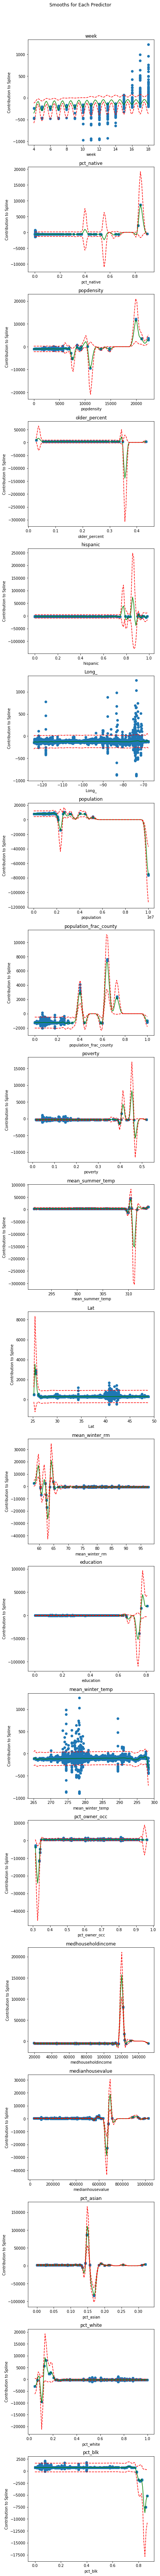

In [125]:
#plot the smooth of each predictor
res = gam_3.deviance_residuals(X_train[predictors_3], X_train.deaths) 
X = X_train[predictors_3]

fig, ax = plt.subplots(20, 1, figsize = (6, 100))

#iterate through each predictor
for i, term in enumerate(gam_3.terms):
    if term.isintercept:
        continue
    XX = gam_3.generate_X_grid(term = i)
    pdep, confi = gam_3.partial_dependence(term = i, X = XX, width=0.95)
    pdep2, _ = gam_3.partial_dependence(term = i, X = X, width=0.95)
    #plt.figure()
    ax[i].scatter(X.iloc[:,term.feature], pdep2 + res)
    ax[i].plot(XX[:, term.feature], pdep, c = 'g')
    ax[i].plot(XX[:, term.feature], confi, c = 'r', ls='--')
    ax[i].set_title(X.columns.values[term.feature])
    ax[i].set_xlabel(X.columns.values[term.feature])
    ax[i].set_ylabel('Contribution to Spline')
    #ax[i].show()

#add title
fig.suptitle('Smooths for Each Predictor')
plt.tight_layout(rect = [0, 0.03, 1, 0.97]);

gam_3.summary()

#### Decision Tree Models

In order to get a stronger understanding of the value of particulate matter data for predicting covid deaths absent parametric constraints and, in general, generate a stronger predictive model for forecasting COVID deaths, we turned to decision tree-based regression models. 

In [156]:
# import useful tree functions
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn import tree as tr

First, we looked at individual decision tree regression. For each of the three ensembles of predictors described previously, we determined optimal tree depth through cross validation and then fit the models, which were evaluated through MSE. We then visualized the tops of the trees (the highest level boundaries) and the relative importances of different predictors. 

In [102]:
depths = list(range(1, 35))

# adapt a function that will cross validate to determine optimal tree depth
def calc_meanstd(X_train, y_train, depths):
    # your code here
    #dict. to store average score for each depth, score on entire training set, and std dev of scores
    cvmeans = {} 
    train_scores = {}
    cvstds = {}
    for i in depths:
        model = DecisionTreeRegressor(max_depth = i) #fit model
        score = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 5, n_jobs = -1, scoring = 'neg_mean_squared_error') #perform 5-fold CV
        cvmeans[i] = -score.mean() #store average score of all 5 folds
        train_scores[i] = mean_squared_error(y_train, model.fit(X_train, y_train).predict(X_train)) #store score on training set
        cvstds[i] = np.std(score)
    # end of your code here
    return cvmeans, cvstds, train_scores

First, we looked at the first ensemble of predictors - just weeks and pm2.5. 

MSE: 1832.332881815148


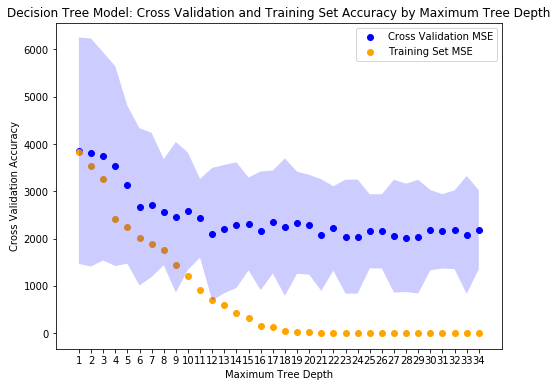

In [158]:
# get the vectors to analyze cross validation scores using function
cvmeans, cvstds, train_scores = calc_meanstd(X_train[predictors_1], X_train.deaths, depths)

# plot - connected 
plt.figure(figsize = (8, 6))
plt.scatter(depths, list(cvmeans.values()), marker='o', label = 'Cross Validation MSE', c = 'blue') #CV scores
plt.scatter(depths, list(train_scores.values()), marker='o', label = 'Training Set MSE', c = 'orange') #training set scores
plt.xticks(depths)
plt.ylabel('Cross Validation Accuracy')
plt.xlabel('Maximum Tree Depth')
plt.title('Decision Tree Model: Cross Validation and Training Set Accuracy by Maximum Tree Depth')
plt.legend()

# fill between lower and upper bounds
lower = [mean - 2 * sd for mean, sd in zip(list(cvmeans.values()), list(cvstds.values()))]
upper = [mean + 2 * sd for mean, sd in zip(list(cvmeans.values()), list(cvstds.values()))]
plt.fill_between(depths, lower, upper, alpha = 0.2, facecolor = 'blue');

# get metrics
model_1 = DecisionTreeRegressor(max_depth = min(cvmeans, key=cvmeans.get))
mse = mean_squared_error(X_test.deaths, model_1.fit(X_train[predictors_1], X_train.deaths).predict(X_test[predictors_1]))
print('MSE:', mse)

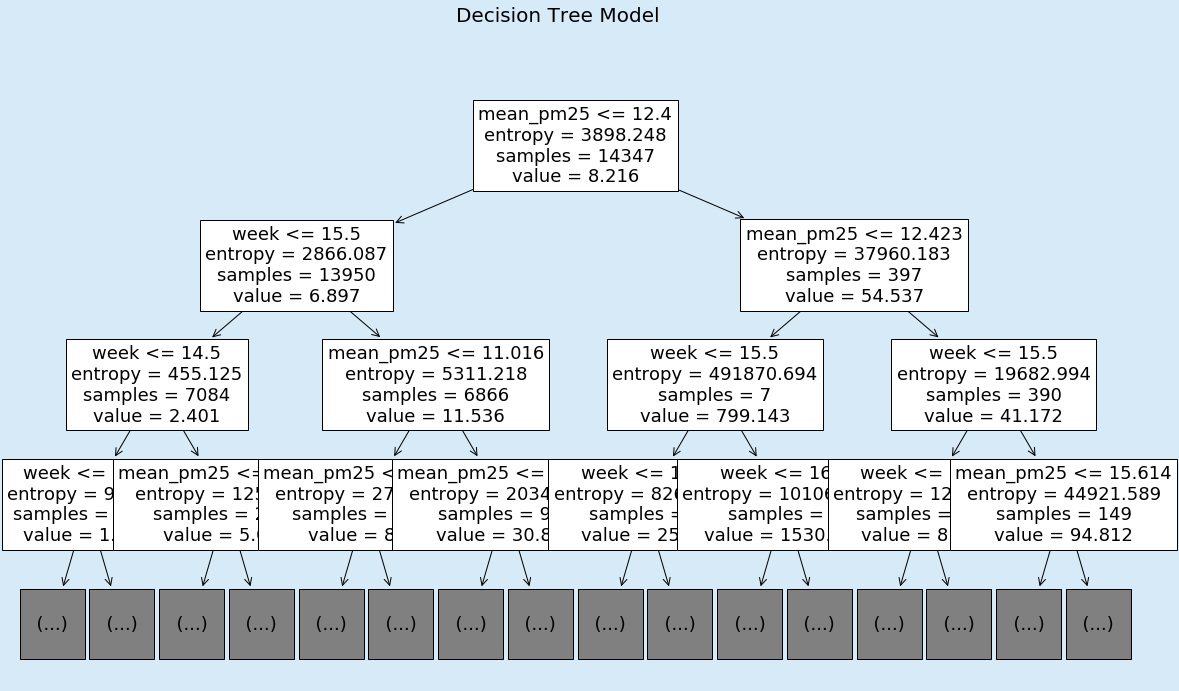

In [159]:
# visualizing the top of the decision tree
plt.figure(figsize = (20, 11), facecolor = '#D6EAF8')
plt.suptitle('Decision Tree Model', fontsize = 20)
tr.plot_tree(model_1, max_depth = 3, feature_names = predictors_1, fontsize = 18);

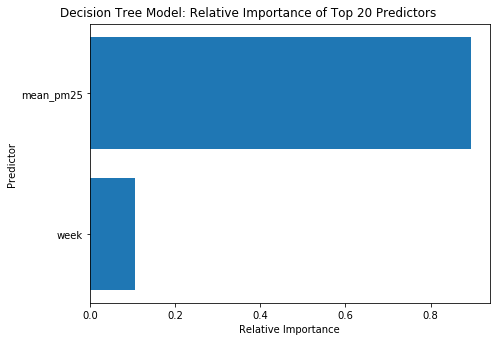

In [165]:
# variable importance plot

# tree: top 20 predictors
tree_top = pd.DataFrame(model_1.feature_importances_,
                                  index = predictors_1,
                                  columns = ['importance']).sort_values('importance', ascending = False)
tree_top['predictor'] = tree_top.index

# plot variable importance
fig, ax = plt.subplots(1, 1, figsize = (7,5))

# tree20 plot
y_pos = np.arange(2)
ax.barh(y_pos, tree_top.importance)
ax.set_yticks(y_pos)
ax.set_yticklabels(tree_top.predictor, fontsize = 10)
ax.tick_params(labelsize=10)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Relative Importance', fontsize = 10)
ax.set_ylabel('Predictor', fontsize = 10)

fig.suptitle('Decision Tree Model: Relative Importance of Top 20 Predictors', fontsize = 12);
# fig.tight_layout()
fig.tight_layout(rect = [0, 0.04, 1, 0.96])

MSE: 392.6122732419462


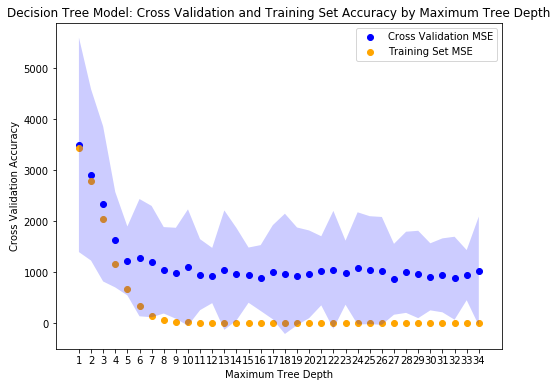

In [166]:
# get the vectors to analyze cross validation scores using function
cvmeans, cvstds, train_scores = calc_meanstd(X_train[predictors_2], X_train.deaths, depths)

# plot - connected 
plt.figure(figsize = (8, 6))
plt.scatter(depths, list(cvmeans.values()), marker='o', label = 'Cross Validation MSE', c = 'blue') #CV scores
plt.scatter(depths, list(train_scores.values()), marker='o', label = 'Training Set MSE', c = 'orange') #training set scores
plt.xticks(depths)
plt.ylabel('Cross Validation Accuracy')
plt.xlabel('Maximum Tree Depth')
plt.title('Decision Tree Model: Cross Validation and Training Set Accuracy by Maximum Tree Depth')
plt.legend()

# fill between lower and upper bounds
lower = [mean - 2 * sd for mean, sd in zip(list(cvmeans.values()), list(cvstds.values()))]
upper = [mean + 2 * sd for mean, sd in zip(list(cvmeans.values()), list(cvstds.values()))]
plt.fill_between(depths, lower, upper, alpha = 0.2, facecolor = 'blue');

# get metrics
model_2 = DecisionTreeRegressor(max_depth = min(cvmeans, key=cvmeans.get))
mse = mean_squared_error(X_test.deaths, model_2.fit(X_train[predictors_2], X_train.deaths).predict(X_test[predictors_2]))
print('MSE:', mse)

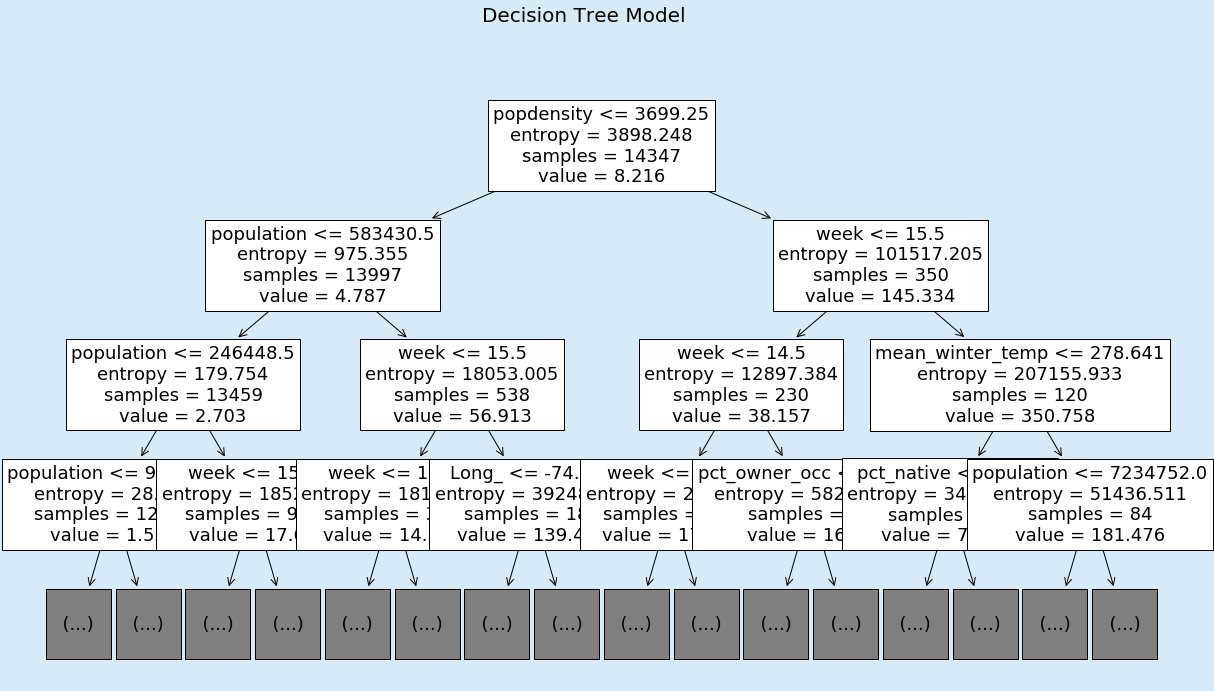

In [167]:
# visualizing the top of the decision tree
plt.figure(figsize = (20, 11), facecolor = '#D6EAF8')
plt.suptitle('Decision Tree Model', fontsize = 20)
tr.plot_tree(model_2, max_depth = 3, feature_names = predictors_2, fontsize = 18);

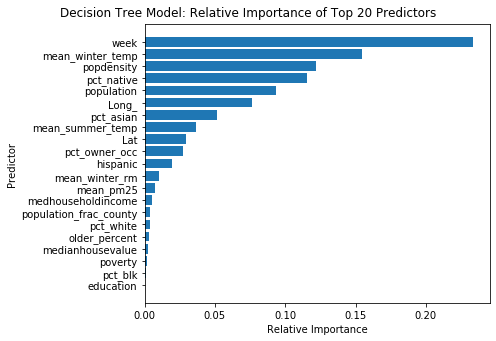

In [168]:
# variable importance plot

# tree: top 20 predictors
tree_top = pd.DataFrame(model_2.feature_importances_,
                                  index = predictors_2,
                                  columns = ['importance']).sort_values('importance', ascending = False)
tree_top['predictor'] = tree_top.index

# plot variable importance
fig, ax = plt.subplots(1, 1, figsize = (7,5))

# tree20 plot
y_pos = np.arange(len(predictors_2))
ax.barh(y_pos, tree_top.importance)
ax.set_yticks(y_pos)
ax.set_yticklabels(tree_top.predictor, fontsize = 10)
ax.tick_params(labelsize=10)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Relative Importance', fontsize = 10)
ax.set_ylabel('Predictor', fontsize = 10)

fig.suptitle('Decision Tree Model: Relative Importance of Top 20 Predictors', fontsize = 12);
# fig.tight_layout()
fig.tight_layout(rect = [0, 0.04, 1, 0.96])

MSE: 401.7426682766293


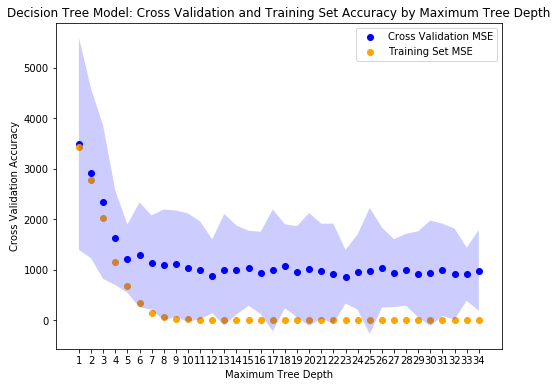

In [113]:
# get the vectors to analyze cross validation scores using function
cvmeans, cvstds, train_scores = calc_meanstd(X_train[predictors_3], X_train.deaths, depths)

# plot - connected 
plt.figure(figsize = (8, 6))
plt.scatter(depths, list(cvmeans.values()), marker='o', label = 'Cross Validation MSE', c = 'blue') #CV scores
plt.scatter(depths, list(train_scores.values()), marker='o', label = 'Training Set MSE', c = 'orange') #training set scores
plt.xticks(depths)
plt.ylabel('Cross Validation Accuracy')
plt.xlabel('Maximum Tree Depth')
plt.title('Decision Tree Model: Cross Validation and Training Set Accuracy by Maximum Tree Depth')
plt.legend()

# fill between lower and upper bounds
lower = [mean - 2 * sd for mean, sd in zip(list(cvmeans.values()), list(cvstds.values()))]
upper = [mean + 2 * sd for mean, sd in zip(list(cvmeans.values()), list(cvstds.values()))]
plt.fill_between(depths, lower, upper, alpha = 0.2, facecolor = 'blue');

# get metrics
model_3 = DecisionTreeRegressor(max_depth = min(cvmeans, key=cvmeans.get))
mse = mean_squared_error(X_test.deaths, model_3.fit(X_train[predictors_3], X_train.deaths).predict(X_test[predictors_3]))
print('MSE:', mse)

Next, we fit random forest regressions. Because of time constraints and an understanding that the predictive capabilities of random forests are most interesting, we did not fit a model on only weeks and pm2.5 but fit models on the full ensemble or predictors and the full ensemble without the particulate matter data. For both sets of predictors, we used cross validation to tune the appropriate number of trees and tree depth for the forest and fit random forest models with the resulting hyperparameters. We evaluated the resulting feature importances. 

In [151]:
###tune n_trees and tree_depth using cross validation

#parameter values to test
np.random.seed(123)
n_trees_list = list(range(100, 301, 50))
tree_depth_list = list(range(10, 40, 5))

#create df to store cross validation results
RF_all_df = pd.DataFrame(list(product(n_trees_list, tree_depth_list)), columns=['n_trees_list', 'tree_depth_list'])

#perform cross validation and store results
for n_trees in n_trees_list:
    for tree_depth in tree_depth_list:
        #set up model; perform 5-fold CV
        RF = RandomForestRegressor(max_features='auto', n_estimators=n_trees, max_depth=tree_depth)
        ###model
        mse2 = cross_val_score(estimator=RF, X=X_train[predictors_2], 
                            y=X_train.deaths, scoring='neg_mean_squared_error', cv=5, n_jobs=-1).mean()
        mse3 = cross_val_score(estimator=RF, X=X_train[predictors_3], 
                            y=X_train.deaths, scoring='neg_mean_squared_error', cv=5, n_jobs=-1).mean()
        #store results in df
        RF_all_df.loc[(RF_all_df.n_trees_list == n_trees) & (RF_all_df.tree_depth_list == tree_depth), 'mse_2'] = mse2
        RF_all_df.loc[(RF_all_df.n_trees_list == n_trees) & (RF_all_df.tree_depth_list == tree_depth), 'mse_3'] = mse3

In [153]:
# find the best parameters from cross validation
max2 = RF_all_df.loc[RF_all_df['mse_2'].idxmax()]
max3 = RF_all_df.loc[RF_all_df['mse_3'].idxmax()]
print("Best Parameters, Model 2:", max2, "\nBest Parameters, Model 3:", max3)
n_trees2, tree_depth2 = int(max2.n_trees_list), int(max2.tree_depth_list)
n_trees3, tree_depth3 = int(max3.n_trees_list), int(max3.tree_depth_list)
# fit random forest regressors with best parameters
RF2 = RandomForestRegressor(max_features='auto', n_estimators=n_trees2, 
                            max_depth=tree_depth2).fit(X_train[predictors_2], X_train.deaths)
mse2 = mean_squared_error(RF2.predict(X_test[predictors_2]), X_test.deaths) 
RF3 = RandomForestRegressor(max_features='auto', n_estimators=n_trees3, 
                            max_depth=tree_depth3).fit(X_train[predictors_3], X_train.deaths)
mse3 = mean_squared_error(RF3.predict(X_test[predictors_3]), X_test.deaths)
# show MSEs
print("MSE Model 2:", mse2, "\nMSE Model 3:", mse3)

Best Parameters, Model 2: n_trees_list       200.000000
tree_depth_list     35.000000
mse_2             -340.489660
mse_3             -361.236059
Name: 17, dtype: float64 
Best Parameters, Model 3: n_trees_list       250.000000
tree_depth_list     30.000000
mse_2             -344.180642
mse_3             -342.296333
Name: 22, dtype: float64
MSE Model 2: 208.257091853018 
MSE Model 3: 231.13032892132622


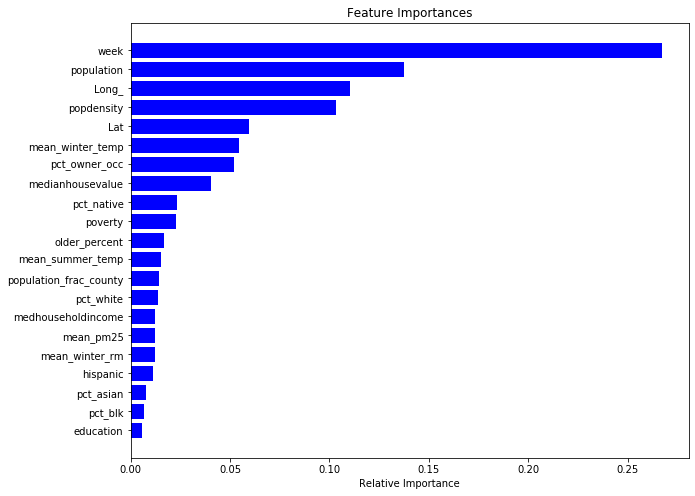

In [154]:
# get the feature importances for the second ensemble
features = X_train[predictors_2].columns
importances = RF2.feature_importances_
indices = np.argsort(importances)

# plot the importances
plt.figure(figsize=(10,8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance');

Finally, we also fit an optimal adaboost model. We used validation set $R^2$ to determine the appropriate number of estimators and depth of trees, as shown in the plot, and fit the optimal model that resulted. For this model, too, we ignored the simplest and smallest set of predictors for the same reason we neglected them for the random forest. Also, due to time constraints, we only found optimal hyperparameters for the full ensemble of predictors without particulate matter data and used those same hyperparameters for the full ensemble. We have reason to believe that the hyperparameters would be similar and that a range of similar hyperparameters generate similar AdaBoost regressions. 

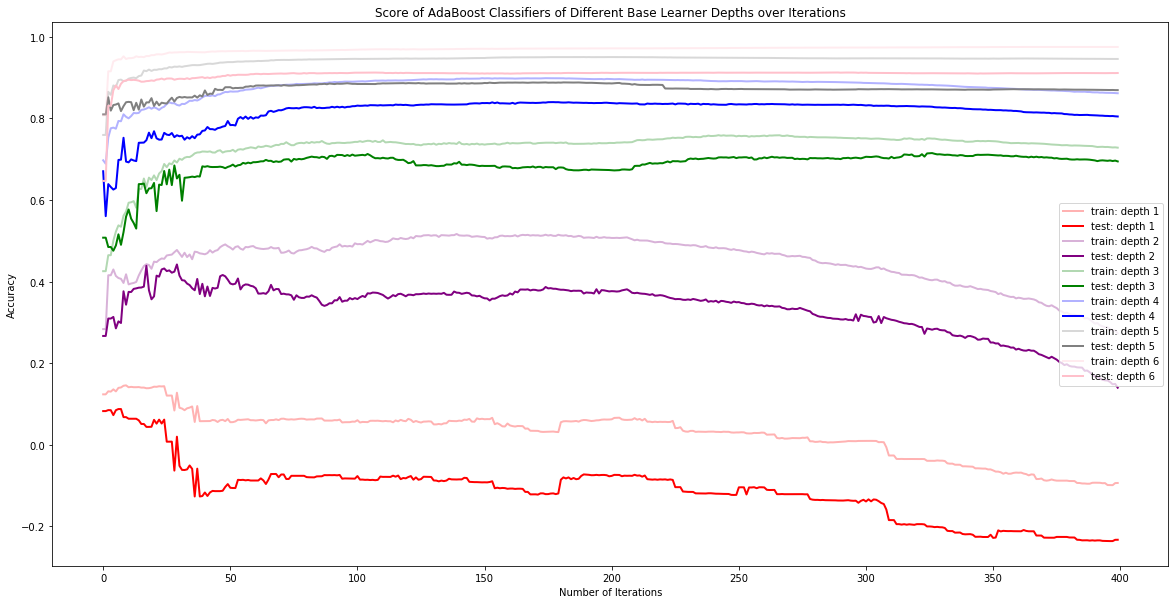

In [134]:
# Iterate over the five depths
colors = ['red', 'purple', 'green', 'blue', 'grey']
plt.figure(figsize = (20, 10))
train_df, val_df = train_test_split(X_train, test_size=.15, random_state = 9)
train_x, train_y = train_df[predictors_3], train_df.deaths
val_x, val_y = val_df[predictors_3], val_df.deaths
for i in range(3, 8):
    # Generate and fit the model
    boost = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth = i), 
                               n_estimators = 400, learning_rate = 0.05).fit(train_x, train_y)
    # Find the scores at different numbers of iterations
    trainsc = boost.staged_score(train_x, train_y)
    testsc = boost.staged_score(val_x, val_y)
    # Plot the scores as a function of the number of iterations
    plt.plot(list(range(400)), list(trainsc), alpha = 0.3, lw = 2, label = 'train: depth {}'.format(i), c = colors[i - 3])
    plt.plot(list(range(400)), list(testsc), alpha = 1, lw = 2, label = 'test: depth {}'.format(i), c = colors[i - 3])
# Add labels to figure
plt.title('Score of AdaBoost Regressions of Different Base Learner Depths over Iterations')
plt.xlabel('Number of Iterations')
plt.ylabel('Accuracy')
plt.legend();

In [137]:
# fit models with best parameters identified, show MSE
boost2 = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth = 6), 
                n_estimators = 100, learning_rate = 0.05).fit(X_train[predictors_2], X_train.deaths)
mse2 = mean_squared_error(boost2.predict(X_test[predictors_2]), X_test.deaths) 
boost3 = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth = 6), 
                n_estimators = 100, learning_rate = 0.05).fit(X_train[predictors_3], X_train.deaths)
mse3 = mean_squared_error(boost3.predict(X_test[predictors_3]), X_test.deaths) 
print("MSE Model 2:", mse2, "\nMSE Model 3:", mse3)

MSE Model 2: 348.8136996143605 /nMSE Model 3: 370.21826210640785


#### Extrapolate Models Until August

**Change Test Dataset to have weeks until September**

We wanted to predict over times not in the data. To that end, we thought it would be useful to ignore our tree-based models, which have fundamental limits with extrapolation in that they rely on nearby data in the training set. GANs, similarly, fit the training set a little too closely to be meaningful. We explore the remaining models, which all happen to be versions of linear regressions. 

In [197]:
# make a dataframe to hold predictions for all weeks
extrapolation_df = pd.DataFrame()
extrapolation_df['week']=range(19,41)
# make a dataframe to hold real data for past weeks
df_graph = df_joined[['week','deaths']].groupby(['week']).agg({'deaths': 'sum'})
df_graph=df_graph.reset_index()
# make a dataframe to use for predicting each week
predictor_data = df_demographic[df_demographic.week == 18]

In [271]:
# create lists of models, model names to iterate over
models = [linear_1, linear_2, linear_3, squared_model_1, squared_model_2, squared_model_3, 
          cubic_model_1, cubic_model_2, cubic_model_3, inter_1, inter_2, inter_3, lasso_1, lasso_2, lasso_3]
modelnames = ['linear_1', 'linear_2', 'linear_3','squared_1', 'squared_2', 'squared_3', 'cubic_1', 'cubic_2', 
              'cubic_3', 'inter_1', 'inter_2', 'inter_3', 'lasso_1', 'lasso_2', 'lasso_3']
counter = 0
# iterate over the models
for model,name in zip(models, modelnames):
    temp_pred_list = []
    # create data to predict with
    if counter % 3 == 0:
        temp_test_df = predictor_data[predictors_1]
    elif counter % 3 == 1:
        temp_test_df = predictor_data[predictors_2]
    else:
        temp_test_df = predictor_data[predictors_3]
    # iterate over future weeks: modify prediciton data and predict
    for y in range(19,41):
        temp_test_df['week'] = y
        if counter > 8:
            interaction = PolynomialFeatures(degree=2, include_bias=True)
            predx = interaction.fit_transform(temp_test_df)
        else: 
            predx = temp_test_df
        temp_pred_list.append(round(model.predict(predx).sum(),0))
    extrapolation_df[name]=temp_pred_list
    print('done with: ', name)
    counter += 1

done with:  linear_1
done with:  linear_2
done with:  linear_3
done with:  squared_1
done with:  squared_2
done with:  squared_3
done with:  cubic_1
done with:  cubic_2
done with:  cubic_3
done with:  inter_1
done with:  inter_2
done with:  inter_3
done with:  lasso_1
done with:  lasso_2
done with:  lasso_3


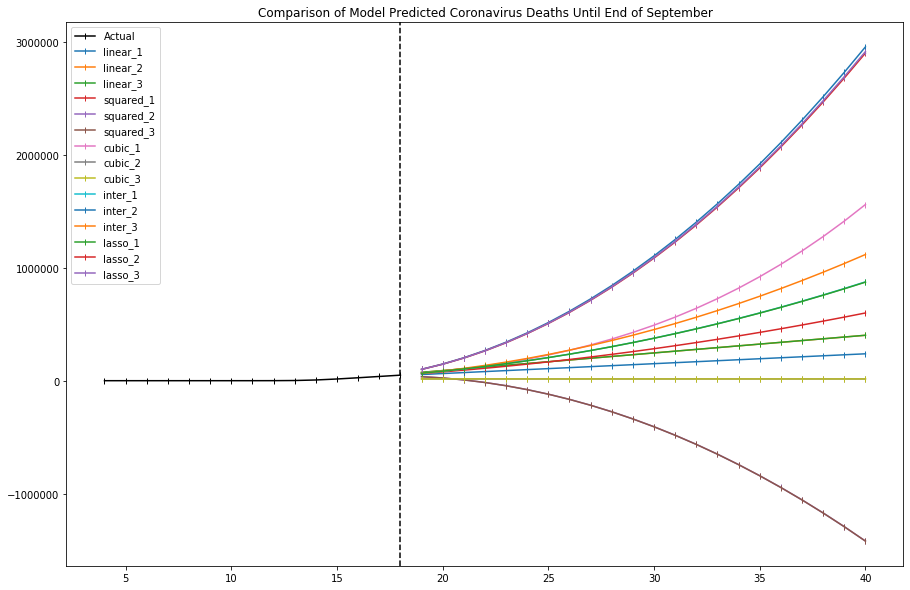

In [273]:
# plot the predictions over time
import matplotlib.pyplot as plt
import numpy as np
 
fig=plt.figure(figsize=(15, 10))
ax=fig.add_subplot(111)

ax.plot(df_graph['week'],df_graph['deaths'],marker="|",label='Actual',c='k',fillstyle='none')
for i in range(15):
    ax.plot(extrapolation_df['week'],extrapolation_df[modelnames[i]],marker="|",label=modelnames[i],fillstyle='none')
ax.axvline(x=18, color='k', linestyle='--')

plt.title("Comparison of Model Predicted Coronavirus Deaths Until End of September") #excluding 28 localities (NYC)
plt.legend(loc=2)
plt.show()


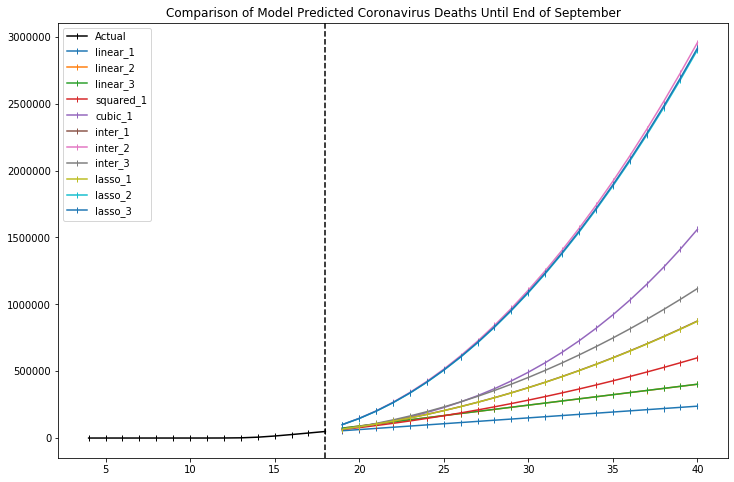

In [288]:
# plot the predictions over time but drop outliers
import matplotlib.pyplot as plt
import numpy as np
 
fig=plt.figure(figsize=(12, 8))
ax=fig.add_subplot(111)

ax.plot(df_graph['week'],df_graph['deaths'],marker="|",label='Actual',c='k',fillstyle='none')
for i in [0, 1, 2,3,6,9,10,11,12,13,14]:
    ax.plot(extrapolation_df['week'],extrapolation_df[modelnames[i]],marker="|",label=modelnames[i],fillstyle='none')
ax.axvline(x=18, color='k', linestyle='--')

plt.title("Comparison of Model Predicted Coronavirus Deaths Until End of September") #excluding 28 localities (NYC)
plt.legend(loc=2)
plt.show();


In [ ]:
blah